📊 Dataset shape: (303, 14)

📋 Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

🧩 Variable types:
 age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

🔎 პირველი ჩანაწერები:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



🎯 Target column: target

Class distribution:
target
1    165
0    138
Name: count, dtype: int64


<Axes: title={'center': 'Target Distribution'}, xlabel='target'>

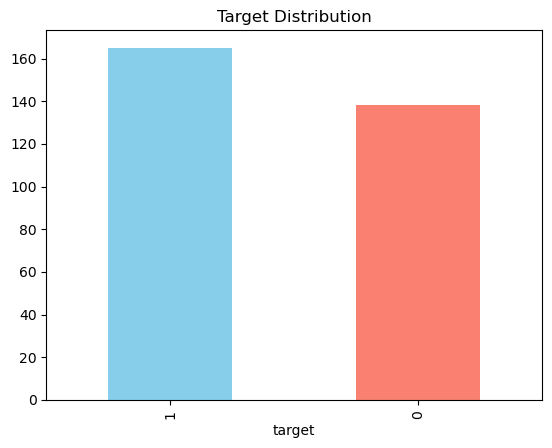

In [1]:
# 1.1 მონაცემების ჩატვირთვა და სტრუქტურის შესწავლა
import pandas as pd
import numpy as np

# ფაილის ჩატვირთვა (გაასწორე ბილიკი საჭიროებისამებრ)
df = pd.read_csv("heart (1).csv", sep=None, engine='python')

print("📊 Dataset shape:", df.shape)
print("\n📋 Columns:", df.columns.tolist())
print("\n🧩 Variable types:\n", df.dtypes)
print("\n🔎 პირველი ჩანაწერები:")
display(df.head())

# Target column-ის იდენტიფიცირება
target_col = 'target' if 'target' in df.columns else df.columns[-1]
print("\n🎯 Target column:", target_col)

# Target-ის განაწილება
print("\nClass distribution:")
print(df[target_col].value_counts())
df[target_col].value_counts().plot(kind='bar', title='Target Distribution', color=['skyblue', 'salmon'])


In [2]:
# დუბლიკატების წაშლა — მხოლოდ ბოლო დატოვეთ
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates(keep='last')
print("Duplicates after:", df.duplicated().sum())

# გამოტოვებული მნიშვნელობები
print("\nMissing values per column:")
print(df.isnull().sum())

# median/mode შევსების სტრატეგია
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

for col in df.columns:
    if df[col].isnull().any():
        if col in numeric_cols:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("\n✅ Missing values handled successfully.")


Duplicates before: 1
Duplicates after: 0

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

✅ Missing values handled successfully.


In [3]:
from sklearn.preprocessing import LabelEncoder

# One-Hot Encoding კატეგორიული ცვლადებისთვის
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# თუ target არ არის რიცხვითი
if not np.issubdtype(df_encoded[target_col].dtype, np.number):
    le = LabelEncoder()
    df_encoded[target_col] = le.fit_transform(df_encoded[target_col])

print("Encoded dataset shape:", df_encoded.shape)
display(df_encoded.head())


Encoded dataset shape: (302, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



🔗 Top correlated features with target:


target      1.000000
cp          0.432080
thalach     0.419955
slope       0.343940
restecg     0.134874
fbs        -0.026826
chol       -0.081437
trestbps   -0.146269
age        -0.221476
sex        -0.283609
Name: target, dtype: float64

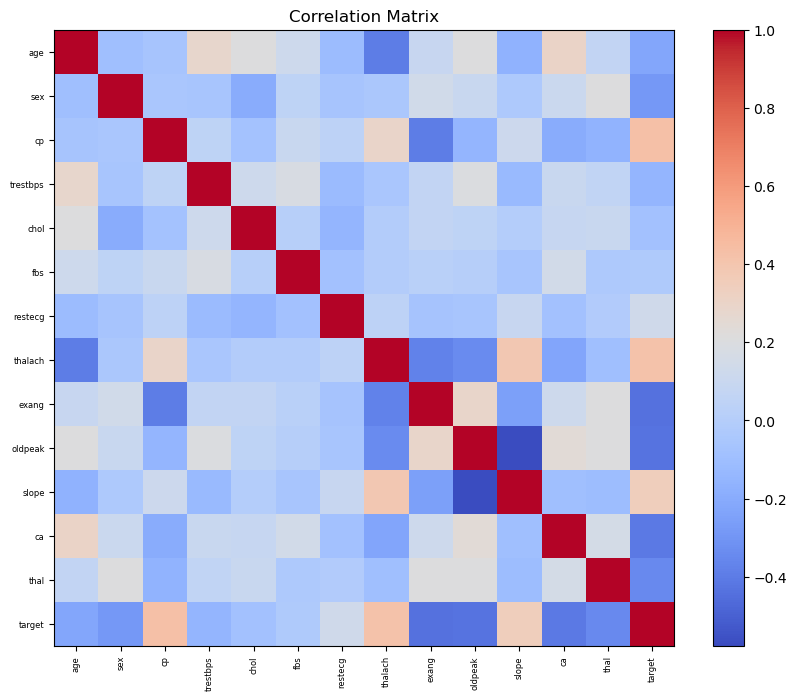

In [4]:
import matplotlib.pyplot as plt

corr_matrix = df_encoded.corr()
target_corr = corr_matrix[target_col].sort_values(ascending=False)

print("\n🔗 Top correlated features with target:")
display(target_corr.head(10))

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.title("Correlation Matrix")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (241, 13)
Test shape: (61, 13)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', GaussianNB())
    ])
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = (model, y_pred)
    print(f"{name} ✅ trained successfully.")


Logistic Regression ✅ trained successfully.
Decision Tree ✅ trained successfully.
Random Forest ✅ trained successfully.
Naive Bayes ✅ trained successfully.



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.78        61



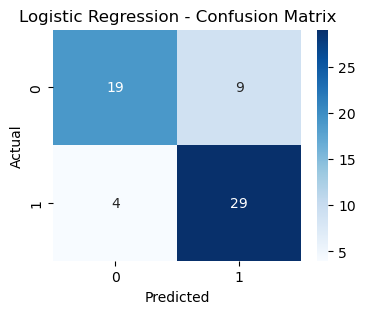


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        28
           1       0.71      0.82      0.76        33

    accuracy                           0.72        61
   macro avg       0.72      0.71      0.71        61
weighted avg       0.72      0.72      0.72        61



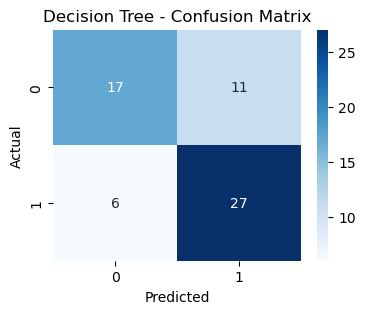


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61



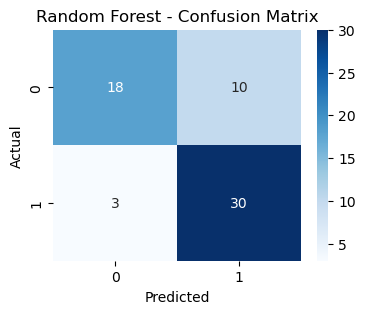


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



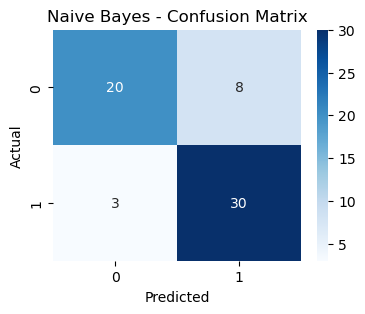

,Model,Accuracy,Precision,Recall,F1
3,Naive Bayes,0.819672,0.789474,0.909091,0.845070
2,Random Forest,0.786885,0.750000,0.909091,0.821918
0,Logistic Regression,0.786885,0.763158,0.878788,0.816901
1,Decision Tree,0.721311,0.710526,0.818182,0.760563


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

metrics = []

for name, (model, y_pred) in results.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append([name, acc, prec, rec, f1])
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# შედეგების ცხრილი
results_df = pd.DataFrame(metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
display(results_df.sort_values(by="F1", ascending=False))


In [8]:
results_df.to_csv("model_metrics.csv", index=False)
print("📁 Metrics saved to model_metrics.csv")


📁 Metrics saved to model_metrics.csv
